# Assignment 9: 3D Genome

### Working with the HiC data

In [1]:
#!/usr/bin/env python2
import hifive
import matplotlib.pyplot as plt
import numpy as np
import math
import pyBigWig

In [2]:
hic=hifive.HiC('/Users/cmdb/qbb2020-answers/assignment9/mm9.project', 'r')

In [3]:
#get the hic data for chromosome 13
data = hic.cis_heatmap('chr13', 1000000, datatype='fend', arraytype='full', diagonalincluded=True)

Finding fend full array for chr13:1000000-120250001... Done


In [4]:
#add a +1 pseudocount to each of the read interactions for log transformation
data_transformed = data + 1

#log transform data, then add another psuedocount of 1
data_transformed = np.log10(data_transformed)
data_transformed = data_transformed + 1

#calculate enrichment scores
enrichment = data_transformed[:,:,0]/data_transformed[:,:,1]


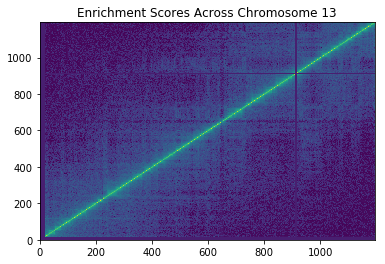

In [5]:
#plot the enrichment scores
fig, ax = plt.subplots()
ax.pcolor(enrichment)
ax.set_title("Enrichment Scores Across Chromosome 13")
fig.savefig('Chromosome13_Heatmap.png')
plt.show()

### Compartment Analysis

In [6]:
#create bed file with compartment scores
Comp = hifive.hic_domains.Compartment(hic, 100000, chroms=['chr13'], out_fname='tmp.hdf5')
Comp.write_eigen_scores('hic_comp.bed')

Casting complex values to real discards the imaginary part


In [7]:
#genomic positions
X = Comp.positions['chr13']
#compartment values
Y = Comp.eigenv['chr13']

Casting complex values to real discards the imaginary part


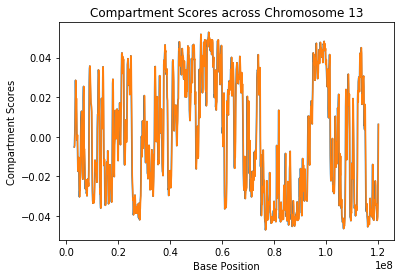

In [8]:
#plot compartment scores across bins of chrom13
fig, ax = plt.subplots()
ax.plot(X,Y)
ax.set_xlabel('Base Position')
ax.set_ylabel('Compartment Scores')
ax.set_title('Compartment Scores across Chromosome 13')
fig.savefig('Compartment_Score_Plot.png')
plt.show()

In [9]:
#sort the genes into compartment score files from the command line using 
#bedtools intersect and awk

#plot the FPKM values of genes after they have been separated
#by positive or negative compartment scores

#grab the FPKM values from files
neg_compartment_fpkm = []
pos_compartment_fpkm = []
neg_compartment_file = "/Users/cmdb/qbb2020-answers/assignment9/neg_compartment_genes"
pos_compartment_file = "/Users/cmdb/qbb2020-answers/assignment9/pos_compartment_genes"
with open(neg_compartment_file, 'r') as f:
    for line in f:
        fields = line.rstrip().split('\t')
        #FPKM is the 5th column of the separated bed files
        fpkm = math.log10(float(fields[4])+1)
        neg_compartment_fpkm.append(fpkm)
        
with open(pos_compartment_file, 'r') as f:
    for line in f:
        fields = line.rstrip().split('\t')
        #FPKM is the 5th column of the separated bed files
        fpkm = math.log10(float(fields[4])+1)
        pos_compartment_fpkm.append(fpkm)
        
#convert the fpkm into an array format for matplotlib violin plot input         
neg_compartment_fpkm_array = np.asarray(neg_compartment_fpkm)
pos_compartment_fpkm_array = np.asarray(pos_compartment_fpkm) 
fpkms = [neg_compartment_fpkm_array,pos_compartment_fpkm_array]


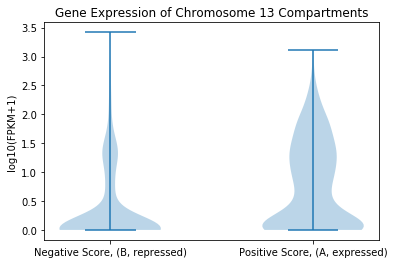

In [10]:
#generate the violin plots using the log FPKM values
fig, ax = plt.subplots()
ax.violinplot(fpkms)
ax.set_xticks([1,2])
ax.set_xticklabels(['Negative Score, (B, repressed)', 'Positive Score, (A, expressed)'])
ax.set_ylabel('log10(FPKM+1)')
ax.set_title("Gene Expression of Chromosome 13 Compartments")
fig.savefig('Gene_Expression_Violin.png')
plt.show()

### Expression vs Repression

In [11]:
bw = pyBigWig.open('data/WT_H3K27me3.bw')
#bw.stats('chr1', 1100000, 1200000, type='sum')

#parse compartment files for chromosome, start position and end position of genes
neg_compartment_file = "/Users/cmdb/qbb2020-answers/assignment9/neg_compartment_genes"
pos_compartment_file = "/Users/cmdb/qbb2020-answers/assignment9/pos_compartment_genes"

neg_chroms = []
neg_starts = []
neg_ends = []

pos_chroms = []
pos_starts = []
pos_ends = []

with open(neg_compartment_file, 'r') as f:
    for line in f:
        fields = line.rstrip().split('\t')
        chrom = fields[0]
        start = int(fields[1])
        end = int(fields[2])
        neg_chroms.append(chrom)
        neg_starts.append(start)
        neg_ends.append(end)
        
with open(pos_compartment_file, 'r') as f:
    for line in f:
        fields = line.rstrip().split('\t')
        chrom = fields[0]
        start = int(fields[1])
        end = int(fields[2])
        pos_chroms.append(chrom)
        pos_starts.append(start)
        pos_ends.append(end)
        

In [12]:
#generate H3K27me3_signal scores 
bw = pyBigWig.open('data/WT_H3K27me3.bw')

neg_H3K27me3 = []
pos_H3K27me3 = []

for i, chrom in enumerate(neg_chroms):
    start = neg_starts[i]
    end = neg_ends[i]
    H3K27me3_signal = bw.stats(chrom,start,end, type='sum')[0]
    if H3K27me3_signal == None:
        H3K27me3_signal = 0
    neg_H3K27me3.append(math.log10(H3K27me3_signal+1))
    
for i, chrom in enumerate(pos_chroms):
    start = pos_starts[i]
    end = pos_ends[i]
    H3K27me3_signal = bw.stats(chrom,start,end, type='sum')[0]
    if H3K27me3_signal == None:
        H3K27me3_signal = 0
    pos_H3K27me3.append(math.log10(H3K27me3_signal+1))


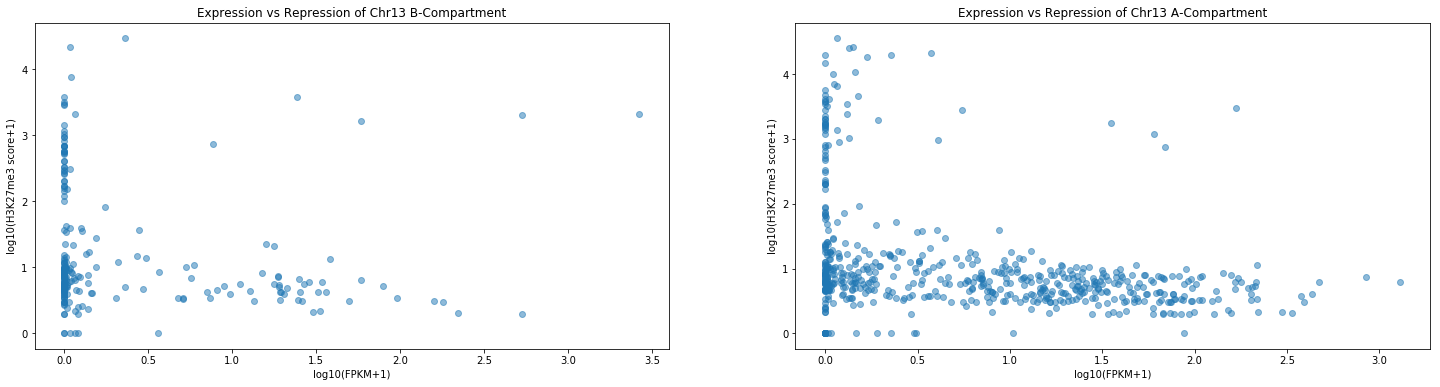

In [13]:
#plot the FPKM expression of genes vs H3K27me3 scores
fig,(ax1, ax2) = plt.subplots(ncols =2, figsize = (25, 6))
ax1.scatter(neg_compartment_fpkm,neg_H3K27me3, alpha = 0.5)
ax2.scatter(pos_compartment_fpkm,pos_H3K27me3, alpha = 0.5)
ax1.set_xlabel('log10(FPKM+1)')
ax1.set_ylabel('log10(H3K27me3 score+1)')
ax1.set_title("Expression vs Repression of Chr13 B-Compartment")
ax2.set_xlabel('log10(FPKM+1)')
ax2.set_ylabel('log10(H3K27me3 score+1)')
ax2.set_title("Expression vs Repression of Chr13 A-Compartment")
fig.savefig('Expression_H3K27me3.png')
plt.show()